In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
import matplotlib.pyplot as plt
from peft import PeftModel, prepare_model_for_kbit_training, LoraConfig, get_peft_model

import json
import warnings
warnings.filterwarnings("ignore")

torch.cuda.empty_cache()
torch.cuda.is_available()
torch.cuda.device_count()

1

### Loading the dataset

In [5]:
dataset = load_dataset("lavita/ChatDoctor-HealthCareMagic-100k")

# Shuffle the dataset
shuffled_dataset = dataset["train"].shuffle(seed=42)  # Using seed for reproducibility

# Split the dataset
train_test_split = shuffled_dataset.train_test_split(test_size=500)  # This sets aside 500 samples for testing
train_dataset = train_test_split["train"]
eval_dataset = train_test_split["test"]

# Considering 5000 samples in total
train_dataset = train_dataset.select(range(4500))  # Selecting the first 4500 samples for training after splitting

print("Features of train dataset:", train_dataset.features)
print("Number of rows in train dataset:", len(train_dataset))
print("Number of rows in test dataset:", len(eval_dataset))


Generating train split:   0%|          | 0/112165 [00:00<?, ? examples/s]

Features of train dataset: {'instruction': Value(dtype='string', id=None), 'input': Value(dtype='string', id=None), 'output': Value(dtype='string', id=None)}
Number of rows in train dataset: 4500
Number of rows in test dataset: 500


### Assigning input/output formats

In [6]:
def format_func(example):
    # This function formats the input and output of the example into a specific string format
    text = f"### Here's an example of the doctor's opinion on a person's query: \n### Patient query: {example['input']} \n### Doctor's response: {example['output']}"
    return text

#### Example of the doctor's opinion on a patient's query:
##### Patient query: I recently noticed a small, painless lump on my neck. Should I be concerned?
##### Doctor's response: Hi, a small, painless lump on your neck can have various causes, such as a swollen lymph node, cyst, or other benign conditions. However, it's important to monitor it for any changes in size, pain, or other symptoms. I recommend scheduling an appointment with your healthcare provider to get a proper evaluation and ensure there is no underlying serious condition. Take care, Chat Doctor.

### Load the Base Model: "Mistral-7B-v0.1", using 4-bit quantization


In [8]:
token = HUGGING_FACE_API_TOKEN  #Add your hugging face API token here
base_model_id = "mistralai/Mistral-7B-v0.1"

#Model Initialization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16 
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, token=token, resume_download=True)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Tokenization

In [9]:
# Load the tokenizer with specific settings
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left", #Padding added to left to make training use less memory
    add_eos_token=True,  # Add End Of Sequence token to the tokenizer
    add_bos_token=True,  # Add Beginning Of Sequence token to the tokenizer
    use_auth_token = 
)
# Set the pad token to the EOS token
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(format_func(prompt))

#### Tokenizing each sample

In [10]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

#### Distribution of our dataset lengths, to determine the appropriate max_length for the input tensors

5000


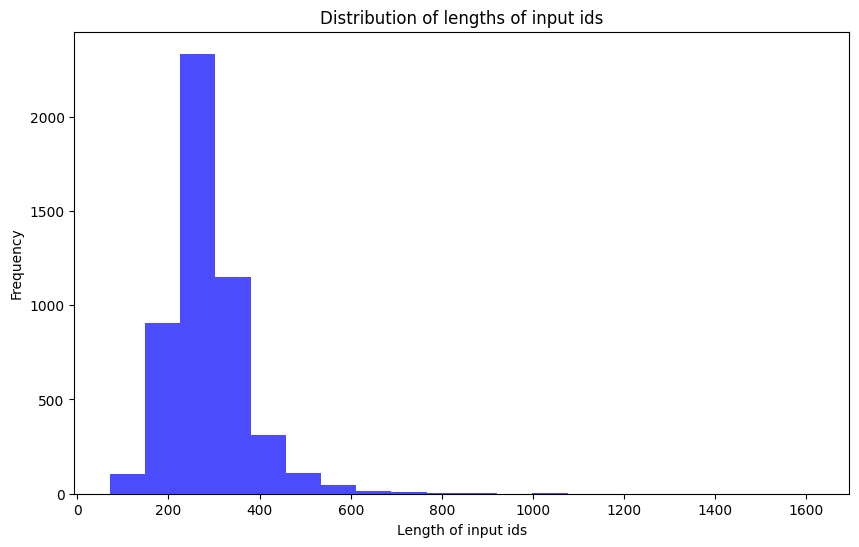

In [11]:
def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of lengths of input ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

### Function to generate and tokenize the prompt

In [14]:
max_length = 512 # considered as an approximate length for the dataset

def generate_and_tokenize_prompt(prompt):
    result = tokenizer(
        format_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

#Tokenize the training data
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
#Tokenize the evaluation data
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

5000


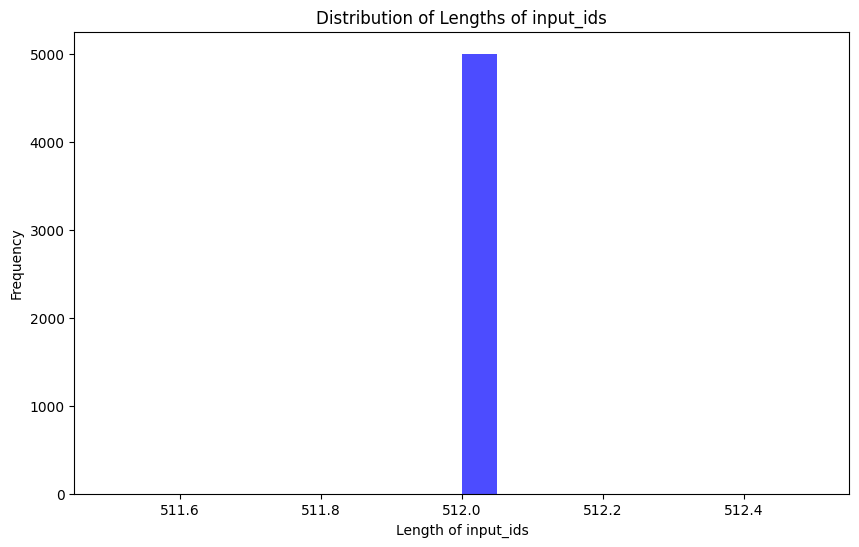

In [16]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

### Base Model Performance

In [16]:
query = "Hi doc, I am recovering after dengue, sometimes my heart feels restless and uncomfortable, what could be the problem?"
eval_prompt = """Patient's Query:\n\n {} \n\n""".format(query)

In [17]:
# Re-init the tokenizer so it doesn't add padding or eos token
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Patient's Query:

 Hi doc, I am recovering after dengue, sometimes my heart feels restless and uncomfortable, what could be the problem? 

Doctor Answer:

Dear Sir/Madam,

Thank you for your query. Dengue is a viral infection that can cause fever, headache, muscle pain, nausea, vomiting, rash, and bleeding problems. In severe cases, it can lead to shock (low blood pressure) and death. The most common symptoms of dengue are high fever, headache, joint and muscle pain, swollen glands, and rash. Other symptoms include loss of appetite, nausea, vomiting, abdominal pain, and diarrhea. Some people may also experience difficulty breathing or chest pain. If you have any of these symptoms, please see a doctor immediately. There is no specific treatment for dengue, but supportive care such as fluids and electrolytes replacement can help manage the condition.


### Setting Up LoRA

In [20]:
def print_trainable_params(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

### Fine-tuning Configuration

In [21]:
config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_params(model)

trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914


In [22]:
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [23]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [24]:
model = accelerator.prepare_model(model)

In [26]:
output_dir

'./mistral-chat-doctor-finetune'

### Model Training

In [ ]:
import transformers
from datetime import datetime

project = "chat-doctor-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=4,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2.5e-4, # Want a small lr for finetuning
        #bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train(resume_from_checkpoint=True)

### Metrics

In [41]:
train_checkpoints_data=json.load(open("./mistral-chat-doctor-finetune/checkpoint-500/trainer_state.json")) 


#### Computing the losses

In [47]:
# Initialize empty lists to store learning rates, training losses, evaluation losses, and steps
learn_rates = []
loss = []
eval_loss = []
steps=[]
# Loop through each entry in the log history from the training checkpoints data
for x in train_checkpoints_data['log_history']:
    try:
        # extracting the learning rate, training loss, and step number
        learn_rates.append(x['learning_rate'])
        loss.append(x['loss'])
        steps.append(x['step'])
    except:
        eval_loss.append(x['eval_loss'])

In [48]:
learn_rates

[0.00023797595190380762,
 0.00022545090180360722,
 0.00021292585170340681,
 0.0002004008016032064,
 0.000187875751503006,
 0.00017535070140280563,
 0.0001628256513026052,
 0.00015030060120240483,
 0.0001377755511022044,
 0.000125250501002004,
 0.00011272545090180361,
 0.0001002004008016032,
 8.767535070140282e-05,
 7.515030060120241e-05,
 6.2625250501002e-05,
 5.01002004008016e-05,
 3.757515030060121e-05,
 2.50501002004008e-05,
 1.25250501002004e-05,
 0.0]

#### Plotting training and evaluation losses against the steps

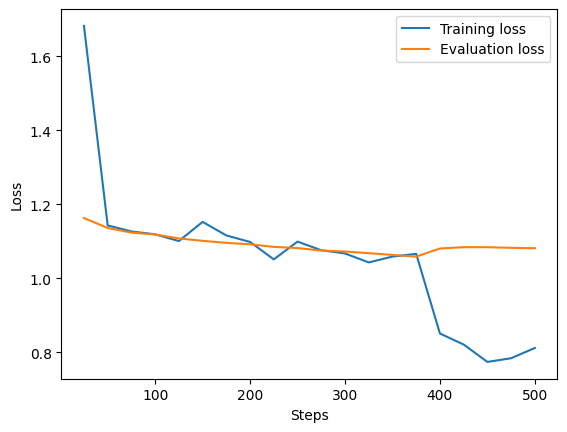

In [44]:
plt.plot(steps, loss, label="Training loss")
plt.plot(steps, eval_loss, label= "Evaluation loss")
leg= plt.legend()
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

In [20]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
token = HUGGING_FACE_API_TOKEN  #Add your hugging face API token here
base_model_id = "mistralai/Mistral-7B-v0.1"

#Setting up the configuration for quantization to make the model run faster and use less memory
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load the base model with the specified configuration
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True
)
# Load the tokenizer that matches the base model
tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [29]:
ft_model = PeftModel.from_pretrained(base_model, "mistral-chat-doctor-finetune/checkpoint-500/")
b_model = AutoModelForCausalLM.from_pretrained(base_model)
fin_model = PeftModel.from_pretrained(b_model, ft_model)
final_model = fin_model.merge_and_unload()
final_model.save_pretrained("healthcare_llm")

### Uploading the model to Hugging Face

In [11]:
import os
from huggingface_hub import HfApi, HfFolder

model_directory = "healthcare_llm"  
model_files = ["config.json", "model.safetensors", "generation_config.json"]

api = HfApi()
username = "Lokesh477"
repo_name = "healthcare_llm"
token = HfFolder.get_token()

for file_name in model_files:
    file_path = os.path.join(model_directory, file_name)
    with open(file_path, "rb") as file:
        api.upload_file(
            token=token,
            repo_id=f"{username}/{repo_name}",
            path_in_repo=file_name,
            path_or_fileobj=file
        )


In [23]:
#Assigning cuda:0 for processing
device0 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device:", device0)

Using device: cuda:0


In [30]:
print("Doc bot chat output:")
print("**********************")
query = " hi doc, my sugar level is 220 what to do?"
eval_prompt = """Patient's Query: {}  answer it promptly in a concise way \n###\n\n""".format(query)
model_input = tokenizer(eval_prompt, return_tensors="pt").to(device0)

output = ft_model.generate(input_ids=model_input["input_ids"].to(device0),
                           attention_mask=model_input["attention_mask"], 
                           max_new_tokens=200, repetition_penalty=1.17)

reference = tokenizer.decode(output[0], skip_special_tokens=True)
print(tokenizer.decode(output[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Doc chat inference:
Patient's Query:  hi doc, my sugar level is 220 what to do?  answer it promptly in a concise way 
###

Answer: Hi there! Thanks for your query. I am sorry that you are suffering from diabetes mellitus (DM). DM is a chronic disease which requires lifelong treatment and management. It can be controlled with proper dietary control, exercise, medication and regular follow up with the doctor. You should consult your treating physician regarding this. He/she will guide you about the best possible treatment plan for you.

I hope this helps. Take care and stay healthy!


In [31]:
def response(query):
    eval_prompt = """Patient's Query: {}  answer it promptly in a concise way and to the point \n\n\n""".format(query)
    model_input = tokenizer(eval_prompt, return_tensors="pt").to(device0)
    output = ft_model.generate(input_ids=model_input["input_ids"].to(device0),
                           attention_mask=model_input["attention_mask"], 
                           max_new_tokens=200, repetition_penalty=1.15)
    result = tokenizer.decode(output[0], skip_special_tokens=True).replace(eval_prompt, "")
    return result

### Output examples generated by the model

In [32]:
response('I am feeling sick after travel and my body is hot what might be reason?')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'Dr. Suresh Kumar Reddy, MD (Ayu)\n\nAnswer:\n\nTraveling from one place to another may cause some health problems due to change of climate, food habits etc. The symptoms like fever, headache, nausea, vomiting, diarrhea are common during traveling. These symptoms can be treated with home remedies.\n\n1. Drink plenty of water or fruit juices.\n2. Avoid eating spicy foods.\n3. Take rest for few days.\n4. Do not take stress.\n5. Eat light diet.\n6. Avoid alcoholic drinks.\n7. Avoid smoking.\n8. Wear loose clothes.\n9. Use air conditioner if possible.\n10. If you have any doubt consult your doctor.'

In [14]:
response('How should I control my thyroid levels?')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'Answer:\n\nDear Sir,\n\nThank you for your query.\n\nThe treatment of hyperthyroidism is based on the severity of symptoms and signs. The first line of therapy is anti-thyroid drugs (ATD) which are given orally. These drugs block the production of thyroid hormones by inhibiting the enzyme that converts T4 into T3. They also reduce the size of the goiter. ATDs include methimazole (MMI), carbamazole (CBZ), propylthiouracil (PTU). MMI is preferred over PTU because of its better safety profile. However, if there is an allergy to MMI then PTU can be used.\n\nIn addition to ATDs, beta-blockers like propranolol may be prescribed to relieve symptoms such as palpitations, tremors, anxiety, etc. Beta-block'

### Chatbot Interface

In [37]:
import gradio as gr

def chat_doctor_response(message):
    return response(message)

interface = gr.Interface(
    fn=chat_doctor_response,
    inputs=gr.Textbox(label="Your Question", placeholder="How can I help you?"),
    outputs="text",
    title="Hey!! It's me DocBot",
    description="Ask any medical question you have.",
    # css=css  # Apply the custom CSS
)

interface.launch(share=True)


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://c4c2a04c1be5c6f4a3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


## Computing Performance Evaluation 



In [27]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [35]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset
import os
from tqdm import tqdm
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
from nltk.translate.meteor_score import meteor_score

# Fine-tuned model name (to load the model weights)
finetuned_model_name = "Lokesh477/healthcare_llm"

# Load the model with the quantization config
try:
    fine_tuned_model = AutoModelForCausalLM.from_pretrained(finetuned_model_name, quantization_config=bnb_config)
except OSError as e:
    print(f"Error loading model: {e}")
    raise

# Load the tokenizer from the base model
try:
    tokenizer = AutoTokenizer.from_pretrained(base_model_id)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
except OSError as e:
    print(f"Error loading tokenizer: {e}")
    raise

# Load the dataset
dataset = load_dataset('truthful_qa', 'generation')

# Prepare the output directory
output_dir = "./evaluation"
os.makedirs(output_dir, exist_ok=True)

def evaluate_metrics(model, tokenizer, dataset, batch_size=6, max_new_tokens=50):
    results = []
    references = []
    bleu_scores = []
    rouge_scores = []
    meteor_scores = []
    
    rouge = Rouge()

    for i in tqdm(range(0, len(dataset["validation"]), batch_size)):
        batch = dataset["validation"][i:i+batch_size]
        inputs = tokenizer(batch["question"], return_tensors="pt", padding=True, truncation=True)
        reference_answers = batch["best_answer"]  # Extract reference answers directly

        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=max_new_tokens)
        decoded_outputs = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
        
        # Store results and references
        results.extend(decoded_outputs)
        references.extend(reference_answers)

        # Calculate metrics
        for ref, hyp in zip(reference_answers, decoded_outputs):
            # Tokenize reference and hypothesis
            ref_tokens = ref.split()
            hyp_tokens = hyp.split()
            
            # BLEU
            bleu_scores.append(sentence_bleu([ref_tokens], hyp_tokens, weights=(0.25, 0.25, 0.25, 0.25)))
            # ROUGE
            try:
                score = rouge.get_scores(hyp, ref)[0]
                rouge_scores.append(score)
            except ValueError:
                rouge_scores.append({'rouge-1': {'f': 0.0}, 'rouge-2': {'f': 0.0}, 'rouge-l': {'f': 0.0}})
            # METEOR
            meteor_scores.append(meteor_score([ref_tokens], hyp_tokens))

    # Calculate average scores
    avg_bleu = np.mean(bleu_scores)
    avg_rouge = {key: np.mean([d[key]['f'] for d in rouge_scores]) for key in ['rouge-1', 'rouge-2', 'rouge-l']}
    avg_meteor = np.mean(meteor_scores)

    return results, references, avg_bleu, avg_rouge, avg_meteor

# Perform evaluation
results, references, avg_bleu, avg_rouge, avg_meteor = evaluate_metrics(fine_tuned_model, tokenizer, dataset, batch_size=6, max_new_tokens=50)

# Save results to file along with metrics
with open(f"{output_dir}/evaluation_metrics.txt", "w") as f:
    f.write(f"===========Average BLEU Score: {avg_bleu}===========\n")
    f.write(f"===========Average ROUGE Scores: {avg_rouge}===========\n")
    f.write(f"===========Average METEOR Score: {avg_meteor}===========\n")
    for result, reference in zip(results, references):
        f.write(f"Generated: {result}\nReference: {reference}\n\n")
    

print("Evaluation completed and results saved!")
print(f"Average BLEU Score: {avg_bleu}\nAverage ROUGE Scores: {avg_rouge}\nAverage METEOR Score: {avg_meteor}\n")



Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now set to True since model is quantized.
  0%|          | 0/137 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
100%|██████████| 137/137 [19:45<00:00,  8.65s/it]

Evaluation completed and results saved!
Average BLEU Score: 0.047078332281463936
Average ROUGE Scores: {'rouge-1': 0.2686367219604025, 'rouge-2': 0.14497031647759837, 'rouge-l': 0.2535409158488689}
Average METEOR Score: 0.3123277218233671



In [36]:

print("Evaluation completed and results saved!")
print(f"Average BLEU Score: {avg_bleu}\nAverage ROUGE Scores: {avg_rouge}\nAverage METEOR Score: {avg_meteor}\n")

Evaluation completed and results saved!
Average BLEU Score: 0.047078332281463936
Average ROUGE Scores: {'rouge-1': 0.2686367219604025, 'rouge-2': 0.14497031647759837, 'rouge-l': 0.2535409158488689}
Average METEOR Score: 0.3123277218233671



### Evaluation Metrics Insights

1. Average BLEU Score: 0.047 - Indicates low similarity in n-gram matches between generated text and reference answers.
2. Average ROUGE Scores:
   a. ROUGE-1: 0.269 - the moderate value suggests the model captures some important words but misses others.
   b. ROUGE-2: 0.145
   c. ROUGE-L: 0.254
     - Implies moderate structural coherence with reference answers but needs improvement.

3. Average METEOR Score: 0.312
- Indicates better semantic similarity and relevance to reference answers.
- Suggests acceptable content relevance despite lower exact n-gram matches.

### Inference
- Moderate performance in generating semantically similar responses.
- Struggles with precise word and phrase matches (low BLEU score).
- Moderate ROUGE scores indicate some important word capture but lack of exact matches.
- Higher METEOR score suggests acceptable semantic content but lacks structural coherence.

### Challenges
- Due to shortage of storage space and GPU accessibility, a small dataset was used for the model.
- Better model evaluation could be observed if a reliable Patient-Doctor chat dataset is used.
